In [1]:
from test_materials import paramarama, shhhh
from philoso_py import ModelFactory
from collections import defaultdict, OrderedDict
import numpy as np
import pandas as pd
import torch
import sys

In [2]:
class ExploreActions:
    def __init__(self, params=None):
        self.mf = ModelFactory()
        self.model = self.make_model_from_json(params=params)

    @shhhh
    def make_model_from_json(self, params=None):
        params = paramarama if params is None else params
        return self.mf.from_json(params)

    def __getitem__(self, key):
        return self.model.agents[0].actions[key]

In [3]:
ea = ExploreActions()
gpn = ea['gp_new']
gpn.action_space

Dict('gp_register': Discrete(2), 'long_box': Box(-inf, inf, (14,), float32))

In [4]:
action = gpn.process_action(
    OrderedDict({
        'gp_register': torch.tensor([[0]]),
        'long_box': torch.tensor([[
            0.0, 0.0, 0.0, 0.0,
            0.0, 0.0, 0.0, 0.0,
            0.0, 0.0, 0.0, 0.0,
            0.0, 12.0
        ]])
    })
)
gpn._interpret(*action)

{'gp_register': 0,
 'obs_centre': 0.0,
 'obs_log_radius': 0.0,
 'obs_width': 2.0,
 'tf_choices': None,
 'tf_weights': None,
 'sra_tf_log_float_const_sd': array([0.], dtype=float32),
 'temp_coeff': 1.0,
 'sb_weights': array([1.]),
 'pop': 26,
 'crossover_rate': 0.5,
 'mutation_rate': 0.5,
 'mutation_sd': 0.0,
 'max_depth': 9,
 'max_size': 27,
 'episode_len': 26,
 'elitism': 13,
 'mutator_weights_0': 0.3333333333333333,
 'mutator_weights_1': 0.6666666666666666}

In [5]:
def raw_2_mut_sd(raw):
    action = gpn.process_action(
        OrderedDict({
            'gp_register': torch.tensor([[1]]),
            'long_box': torch.tensor([[
                0.5, -0.5, 2.0,     # pop, max_size, episode_len
                2.0,                # crossover_rate
                -2.0,               # mutation_rate
                raw,                # log_mutation_sd -> mutation_sd
                18.0,               # max_depth
                0.0,
                0.0, 0.0, 0.0, 0.0,
                1.0, 1.0
            ]])
        })
    )
    return gpn._interpret(*action)['mutation_sd']


In [6]:
X = np.arange(-19.1, -18.9, 0.00001)
Y = np.array([raw_2_mut_sd(x) for x in X])

<Axes: xlabel='raw_mut_sd', ylabel='mut_sd'>

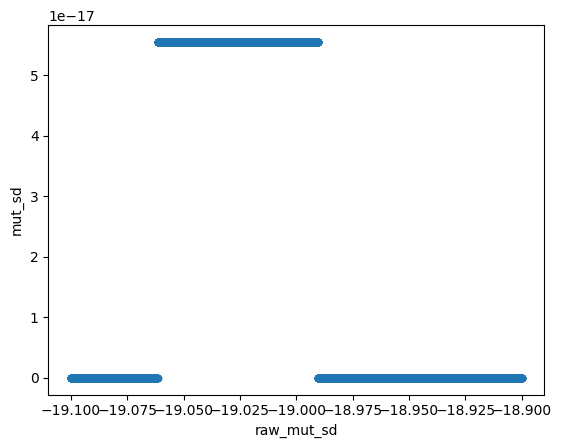

In [7]:
pd.DataFrame({'raw_mut_sd': X, 'mut_sd': Y}).plot.scatter('raw_mut_sd', 'mut_sd')

In [8]:
Y

array([0., 0., 0., ..., 0., 0., 0.], shape=(20001,))

In [9]:
X

array([-19.1    , -19.09999, -19.09998, ..., -18.90002, -18.90001,
       -18.9    ], shape=(20001,))

In [10]:
X[Y>0]

array([-19.06154, -19.06153, -19.06152, ..., -18.99037, -18.99036,
       -18.99035], shape=(7120,))

In [11]:
gpn.guardrails

GuardrailManager(<function guardrails.GuardrailManager.__init__.<locals>.<lambda>()>,
                 {'pop': TanhGuardrail([-18.990341103219276, 18.990341103219276], [2, inf]),
                  'max_size': TanhGuardrail([-18.990341103219276, 18.990341103219276], [3, inf]),
                  'episode_len': TanhGuardrail([-18.990341103219276, 18.990341103219276], [2, inf]),
                  'crossover_rate': TanhGuardrail([-18.990341103219276, 18.990341103219276], [0, 1]),
                  'mutation_rate': TanhGuardrail([-18.990341103219276, 18.990341103219276], [0, 1]),
                  'log_mutation_sd': TanhGuardrail([-18.990341103219276, -18.990340000004153], [-11.512925464970229, 0.0]),
                  'max_depth': TanhGuardrail([-18.990341103219276, 18.990341103219276], [1, inf]),
                  'elitism': TanhGuardrail([-18.990341103219276, 18.990341103219276], [0, 1]),
                  'temp_coeff': TanhGuardrail([-18.990341103219276, 18.990341103219276], [0, inf]),
 

In [149]:
def exp_arg_extreme(float_class: type, min=True):
    targ = 0.0 if min else np.inf
    flip = 1.0 if min else -1.0
    a = float_class(0.0)
    b = float_class(-1.0 * flip) # (1.0)
    a_s, b_s = [a], [b]
    while a!=b :
        if flip*np.exp(b) > flip*targ:
            a, b = b, b-(2*flip*abs(a-b)) 
        elif a==a_s[-2] and b==b_s[-2]:
            a_ = np.nextafter(a, 0.0)
            if np.exp(a_) == targ:
                a = a_ 
            elif np.exp(a) == targ:
                b = a
            else:
                a = b
        elif flip*np.exp(a) > flip*targ:
            qdiff = abs(a-b)/4.0 
            b += flip*qdiff # -=
            a -= flip*qdiff # +=
        else:
            a += flip*abs(a-b)/2 # -=, use abs
        a_s.append(a)
        b_s.append(b)
    return b, a_s, b_s

def exp_argmin(float_class: type):
    a = float_class(0.0)
    b = float_class(-1.0) # (0.0)
    a_s, b_s = [a], [b]
    while a!=b :
        if np.exp(b) > 0.0: # < np.inf
            a, b = b, b-(2*(a-b)) # +
        elif a==a_s[-2] and b==b_s[-2]:
            a_ = np.nextafter(a, 0.0)
            if np.exp(a_) == 0.0: # np.inf
                a = a_ 
                b_ =  nextafter(b, 0.0)
                if np.exp(b_) == 0.0: # np.inf
                    b = b_
                else:
                    a = b
            else:
                b = a
        elif np.exp(a) > 0.0: # np.inf
            qdiff = (a-b)/4.0 # use abs
            b += qdiff # -=
            a -= qdiff # +=
        else:
            a += (a-b)/2 # -=, use abs
        a_s.append(a)
        b_s.append(b)
    return b, a_s, b_s

def exp_argmax(float_class: type):
    a = float_class(0.0)
    b = float_class(1.0)
    a_s, b_s = [a], [b]
    while a!=b :
        if np.exp(b) < np.inf:
            # print('w')
            a, b = b, b+(2*(b-a))
        elif a==a_s[-2] and b==b_s[-2]:
            # print('x')
            a_ = np.nextafter(a, 0.0)
            if np.exp(a_) == np.inf:
                a = a_
                # b_ =  nextafter(b, 0.0)
                # if np.exp(b_) == np.inf:
                #     b = b_
                # else:
                #     a = b
            else:
                b = a
        elif np.exp(a) < np.inf:
            # print('y')
            qdiff = (b-a)/4.0
            b -= qdiff
            a += qdiff
        else:
            # print('z')
            a -= (b-a)/2
        a_s.append(a)
        b_s.append(b)
        # print(a, b)
    print(b, 'B')
    return b, a_s, b_s

def show_exp_arg_extremum1(float_class: type, min=True):
    b, a_s, b_s = exp_arg_extreme(float_class, min=min)
    m = 'min' if min else 'max'
    title = f"arg{m} of np.exp of {float_class.__name__} = {b}"
    df = pd.DataFrame({'A': a_s, 'B': b_s, 't': list(range(len(a_s)))})
    ax = df.plot('t', 'A', title=title)
    df.plot('t', 'B', ax=ax)
    print(b, np.exp(b), np.exp(np.nextafter(b, -np.inf)), np.exp(np.nextafter(b, np.inf)))


def show_exp_arg_extremum2(float_class: type, min=True):
    if min:
        b, a_s, b_s = exp_argmin(float_class)
        m = 'min'
    else:
        b, a_s, b_s = exp_argmax(float_class)
        m = 'max'
    title = f"arg{m} of np.exp of {float_class.__name__} = {b}"
    df = pd.DataFrame({'A': a_s, 'B': b_s, 't': list(range(len(a_s)))})
    ax = df.plot('t', 'A', title=title)
    df.plot('t', 'B', ax=ax)
    print(b, np.exp(b), np.exp(np.nextafter(b, -np.inf)), np.exp(np.nextafter(b, np.inf)))


-745.1332191019412 0.0 0.0 5e-324
-103.97209 0.0 0.0 0.0
-17.34 0.0 0.0 6e-08
-745.1332191019412 0.0 0.0 5e-324
709.7827128933841 inf 1.7976931348622732e+308 inf
88.72284 inf 3.4027985e+38 inf
11.09 inf 65250.0 inf
709.7827128933841 inf 1.7976931348622732e+308 inf


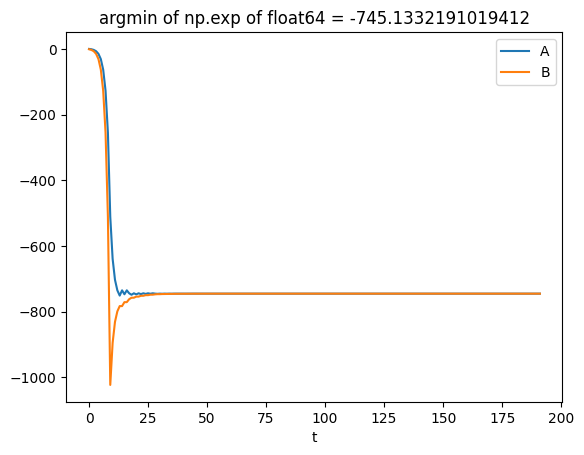

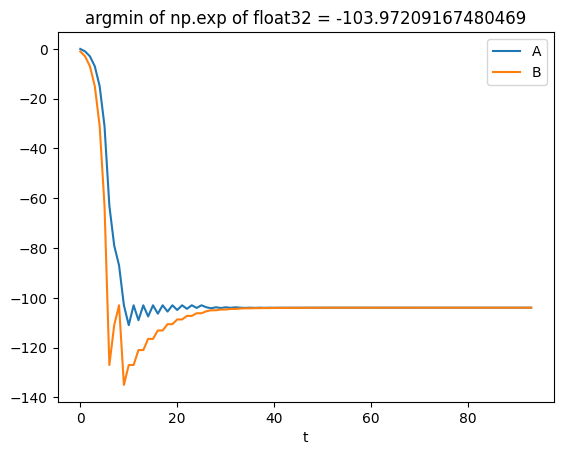

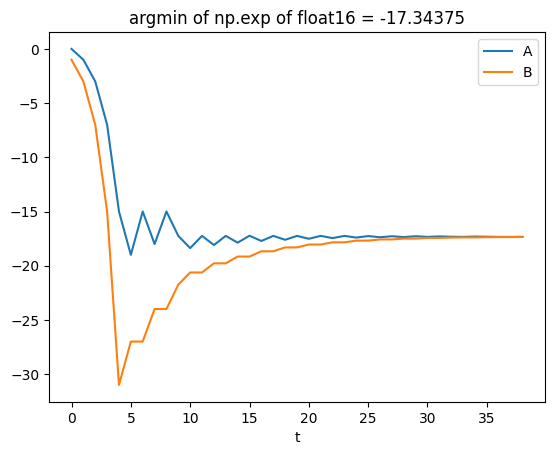

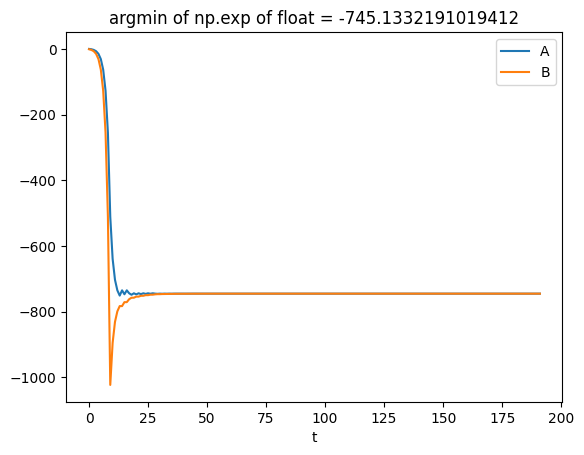

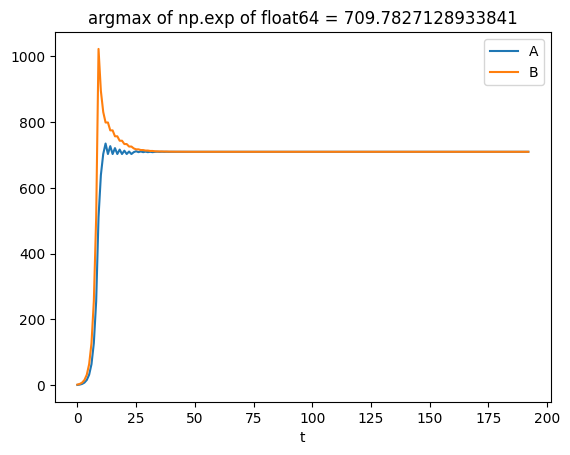

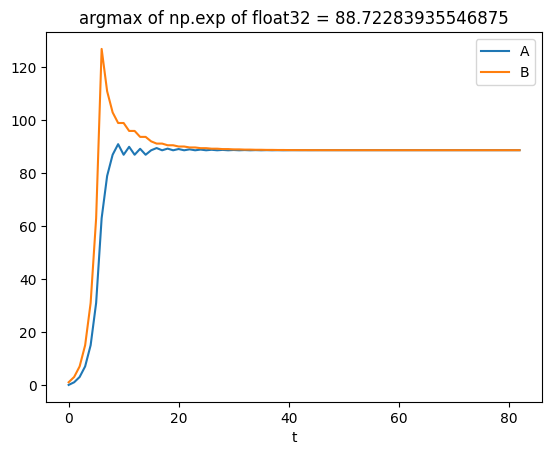

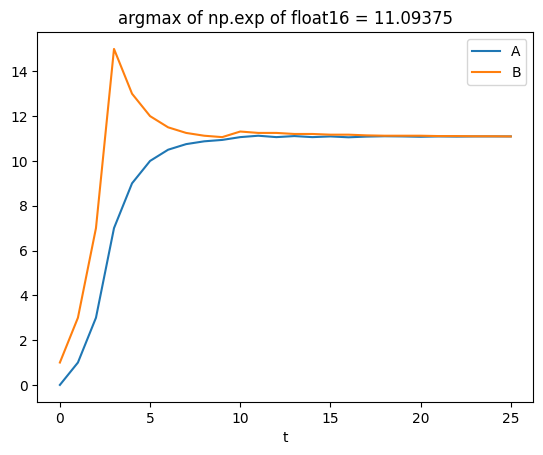

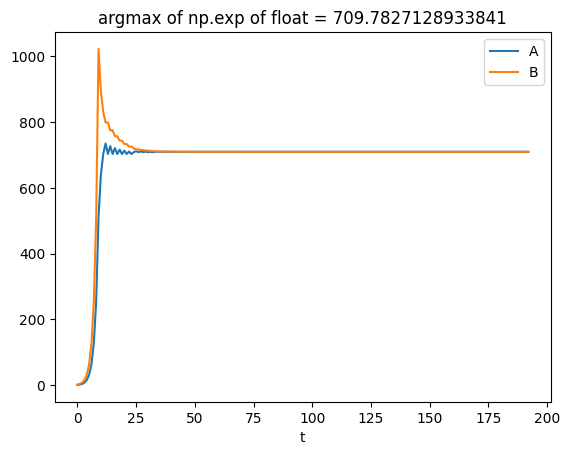

In [151]:
show_exp_arg_extremum1(np.float64)
# show_exp_arg_extremum2(np.float64)
show_exp_arg_extremum1(np.float32)
# show_exp_arg_extremum2(np.float32)
show_exp_arg_extremum1(np.float16)
# show_exp_arg_extremum2(np.float16)
show_exp_arg_extremum1(float)
# show_exp_arg_extremum2(float)
show_exp_arg_extremum1(np.float64, min=False)
# show_exp_arg_extremum2(np.float64, min=False)
show_exp_arg_extremum1(np.float32, min=False)
# show_exp_arg_extremum2(np.float32, min=False)
show_exp_arg_extremum1(np.float16, min=False)
# show_exp_arg_extremum2(np.float16, min=False)
show_exp_arg_extremum1(float, min=False)
# show_exp_arg_extremum2(float, min=False)

In [140]:
float.__dict__

mappingproxy({'__new__': <function float.__new__(*args, **kwargs)>,
              '__repr__': <slot wrapper '__repr__' of 'float' objects>,
              '__hash__': <slot wrapper '__hash__' of 'float' objects>,
              '__getattribute__': <slot wrapper '__getattribute__' of 'float' objects>,
              '__lt__': <slot wrapper '__lt__' of 'float' objects>,
              '__le__': <slot wrapper '__le__' of 'float' objects>,
              '__eq__': <slot wrapper '__eq__' of 'float' objects>,
              '__ne__': <slot wrapper '__ne__' of 'float' objects>,
              '__gt__': <slot wrapper '__gt__' of 'float' objects>,
              '__ge__': <slot wrapper '__ge__' of 'float' objects>,
              '__add__': <slot wrapper '__add__' of 'float' objects>,
              '__radd__': <slot wrapper '__radd__' of 'float' objects>,
              '__sub__': <slot wrapper '__sub__' of 'float' objects>,
              '__rsub__': <slot wrapper '__rsub__' of 'float' objects>,
        

In [159]:
boundary = 5.0
coefficient = 2.0
(boundary if boundary is not None else np.inf) * coefficient

10.0